<a href="https://colab.research.google.com/github/Ankur3107/colab_notebooks/blob/master/Bert_Classification_Pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/SrinidhiRaghavan/AI-Sentiment-Analysis-on-IMDB-Dataset/master/imdb_tr.csv

--2020-08-25 15:35:11--  https://raw.githubusercontent.com/SrinidhiRaghavan/AI-Sentiment-Analysis-on-IMDB-Dataset/master/imdb_tr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23677025 (23M) [text/plain]
Saving to: ‘imdb_tr.csv’

imdb_tr.csv         100%[===================>]  22.58M  40.2MB/s    in 0.6s    

2020-08-25 15:35:12 (40.2 MB/s) - ‘imdb_tr.csv’ saved [23677025/23677025]



In [2]:
!pip install transformers

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 16.4MB/s 
     |████████████████████████████████| 890kB 20.7MB/s 
     |████████████████████████████████| 3.0MB 32.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=2a9fd2beb4fbd53b26145bf94bd8620825bcc7e90e60157fd5279762b00f2801
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
from collections import defaultdict
import numpy as np
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import *
from sklearn.model_selection import train_test_split
import logging
import os, pandas as pd

# Data Preparation

In [4]:
!head imdb_tr.csv

row_Number,text,polarity
2148,"first think another Disney movie, might good, it's kids movie. watch it, can't help enjoy it. ages love movie. first saw movie 10 8 years later still love it! Danny Glover superb could play part better. Christopher Lloyd hilarious perfect part. Tony Danza believable Mel Clark. can't help, enjoy movie! give 10/10!",1
23577,"Put aside Dr. House repeat missed, Desperate Housewives (new) watch one. don't know exactly plagued movie. never thought I'd say this, want 15 minutes fame back.<br /><br />Script, Direction, can't say. recognized stable actors (the usual suspects), thought Herbert Marshall class addition sat good cheesy flick. Boy, wrong. Dullsville.<br /><br />My favorite parts: ""office girl"" makes 029 keypunch puts cards 087 sorter. LOL @ ""the computer"". I'd like someone identify next device - 477 ? It's even dinosaur's time.<br /><br />And dinosaurs don't much time waste.",0
1319,"big fan Stephen King's work, film made even greater fan King. Pet

In [5]:
data = pd.read_csv('imdb_tr.csv', encoding = "ISO-8859-1")

In [6]:
del data['row_Number']

In [7]:
data.columns = ["text", "label"]

In [8]:
def get_train_text_df(data):
  train_lines, test_lines, train_labels, test_labels = train_test_split(data['text'], data['label'], test_size=0.20, random_state=3107, stratify=data['label'])
  train_df = pd.DataFrame({'text':train_lines.values, 'label':train_labels.values})
  eval_df = pd.DataFrame({'text':test_lines.values, 'label':test_labels.values})
  return train_df, eval_df


In [9]:
train_df, eval_df = get_train_text_df(data)

In [10]:
train_df.shape, eval_df.shape

((20000, 2), (5000, 2))

In [11]:
MAX_LEN = 256

class TextLabelDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
          
        )

        return {
          'texts': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(label, dtype=torch.long)
        }

In [12]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TextLabelDataset(
        texts=df.text.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
        )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
        )

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
BATCH_SIZE =32

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(eval_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(eval_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [15]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'targets'])

In [16]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


# Model Building

In [17]:
device = 'cuda'
model = BertModel.from_pretrained('bert-base-uncased')

In [18]:
class Classifier(nn.Module):

    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.bert = model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [19]:
all_labels = ['negative','positive']
classifier_model = Classifier(len(all_labels))
classifier_model = classifier_model.to(device)

In [20]:
classifier_model

Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [22]:
EPOCHS = 1

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

# Model Training

In [23]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    classifier_model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train_df)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    classifier_model,
    val_data_loader,
    loss_fn, 
    device, 
    len(eval_df)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(classifier_model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/1
----------


KeyboardInterrupt: ignored

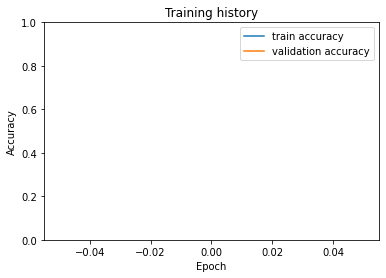

In [26]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Model Evaluation

In [27]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  input_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["texts"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      input_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return input_texts, predictions, prediction_probs, real_values

In [28]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  classifier_model,
  test_data_loader
)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=all_labels))

              precision    recall  f1-score   support

    negative       0.83      0.91      0.87      2500
    positive       0.90      0.81      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.87      0.86      0.86      5000
weighted avg       0.87      0.86      0.86      5000

